In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
df = pd.read_csv("final_merged_df.csv")
df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,6.410498,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,6.410498,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,6.410498,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,6.410498,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,6.410498,1.0,Turkana


### **Data Preparation for Clustering**
Select the relevant columns, including one-hot encoded income columns, for clustering.

In [3]:
#  label encoding income_distribution column
label_encoder = LabelEncoder()

df['Income_Distribution_encoded'] = label_encoder.fit_transform(df['Income_Distribution'])
print(df[['Income_Distribution', 'Income_Distribution_encoded']].head())

  Income_Distribution  Income_Distribution_encoded
0             Turkana                           42
1             Turkana                           42
2             Turkana                           42
3             Turkana                           42
4             Turkana                           42


In [4]:
clustering_data = df[['Pop_Density_2020', 'Wind_Speed', 'Latitude', 'Longitude', 'Grid_Value', 'Income_Distribution_encoded']]

### **Standardize Features**
Standardize the data to bring all features to a similar scale, ensuring they contribute equally to clustering.


In [5]:
# Standardize the data to bring all features to a similar scale
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

**Apply PCA for Dimensionality Reduction**

Reduce to 2 components for visualization and efficiency. This helps capture the primary data variance in fewer dimensions.

In [6]:
# Apply PCA to reduce to a manageable number of components
pca = PCA(n_components=2)  # Adjust to 2 components for efficient clustering
clustering_data_reduced = pca.fit_transform(clustering_data_scaled)

Add PCA components back to the DataFrame for easier access during visualization and further analysis


In [7]:
# Add PCA components back to the DataFrame
df['PCA_Component_1'] = clustering_data_reduced[:, 0]
df['PCA_Component_2'] = clustering_data_reduced[:, 1]

#### HDBSCAN Clustering:

Cluster using HDBSCAN with fine-tuning for optimal parameters.

In [8]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=20, metric='manhattan')
clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
stability_scores = hdbscan_clusterer.probabilities_

In [9]:
# Add clusters and stability scores to DataFrame
df['Cluster'] = clusters
df['Stability_Score'] = stability_scores

##### Feature Engineering with County and Cluster Insights
*Calculate cluster-specific metrics, like average population density and wind speed*

In [18]:
import itertools

In [15]:
# Evaluate Clustering Quality (Exclude Noise Points)
clustered_data = clustering_data_reduced[clusters != -1]
valid_clusters = clusters[clusters != -1]
if len(set(valid_clusters)) > 1:
    db_index = davies_bouldin_score(clustered_data, valid_clusters)
    ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
    print("Initial Davies-Bouldin Index:", db_index)
    print("Initial Calinski-Harabasz Index:", ch_index)
else:
    print("Insufficient clusters for evaluation metrics")

Initial Davies-Bouldin Index: 0.5379327913772385
Initial Calinski-Harabasz Index: 507744.2436115841


In [16]:
# Hyperparameter Tuning with Grid Search
best_params = {}
best_db_index = float('inf')
min_cluster_sizes = [20, 50, 100]
min_samples_options = [5, 10, 20]
metrics = ['euclidean', 'manhattan']

In [19]:
for min_cluster_size, min_samples, metric in itertools.product(min_cluster_sizes, min_samples_options, metrics):
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric)
    clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
    clustered_data = clustering_data_reduced[clusters != -1]
    valid_clusters = clusters[clusters != -1]
    
    if len(set(valid_clusters)) > 1:
        db_index = davies_bouldin_score(clustered_data, valid_clusters)
        if db_index < best_db_index:
            best_db_index = db_index
            best_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples, 'metric': metric}

print("Best Parameters:", best_params)

Best Parameters: {'min_cluster_size': 20, 'min_samples': 20, 'metric': 'euclidean'}


In [24]:
# Reapply HDBSCAN with Optimal Parameters
hdbscan_clusterer = hdbscan.HDBSCAN(**best_params)
clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
stability_scores = hdbscan_clusterer.probabilities_

In [ ]:
# Add clusters and stability scores to DataFrame
df['Cluster'] = clusters
df['Stability_Score'] = stability_scores

In [ ]:
# Final Cluster Evaluation
clustered_data = clustering_data_reduced[clusters != -1]
valid_clusters = clusters[clusters != -1]
if len(set(valid_clusters)) > 1:
    db_index = davies_bouldin_score(clustered_data, valid_clusters)
    ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
    print("Optimal Davies-Bouldin Index:", db_index)
    print("Optimal Calinski-Harabasz Index:", ch_index)
else:
    print("Insufficient clusters for evaluation metrics")

Optimal Davies-Bouldin Index: 0.7524995002473333
Optimal Calinski-Harabasz Index: 4660298.254013014


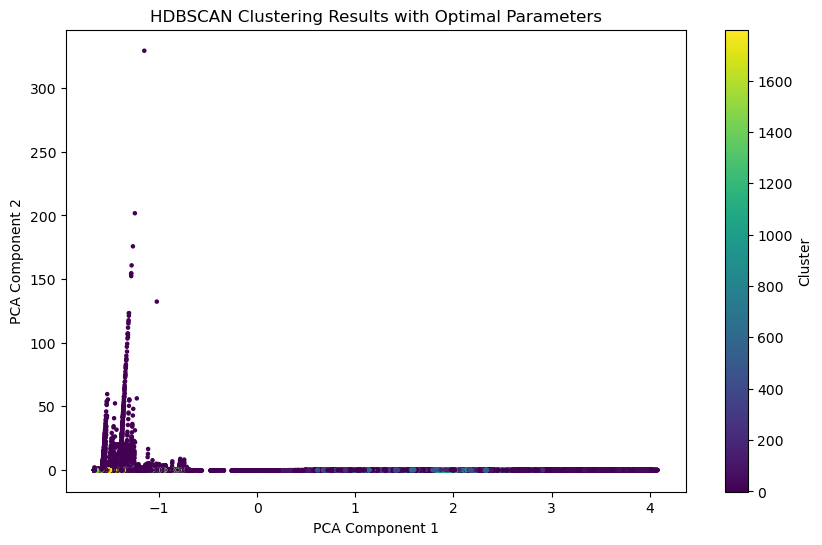

In [ ]:
# Cluster Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c=df['Cluster'], cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('HDBSCAN Clustering Results with Optimal Parameters')
plt.show()

In [29]:
# Apply Rule-Based Labeling for Energy Planning
df['Electrification_Label'] = df.apply(
    lambda row: 
        0 if row['Pop_Density_2020'] > 20 and row['Grid_Value'] > 0.5 else  # Grid extension likely
        1 if row['Pop_Density_2020'] < 20 and row['Wind_Speed'] > 5 else    # Wind microgrid likely
        2, axis=1  # Custom solutions or investigation
)

# Summary of Energy Planning Labels
print("Electrification Label Distribution:")
print(df['Electrification_Label'].value_counts())

Electrification Label Distribution:
Electrification_Label
0    751735
1    406805
Name: count, dtype: int64


In [30]:
# Calculate cluster-level metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Pop_Density_2020': 'mean',
    'Wind_Speed': 'mean'
}).rename(columns={
    'Pop_Density_2020': 'Cluster_Mean_Pop_Density',
    'Wind_Speed': 'Cluster_Mean_Wind_Speed'
})
df = df.merge(cluster_metrics, on='Cluster', how='left')
df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,PCA_Component_2,Cluster,Stability_Score,Cluster_Mean_Pop_Density_x,Cluster_Mean_Wind_Speed_x,Electrification_Label,Cluster_Mean_Pop_Density_y,Cluster_Mean_Wind_Speed_y,Cluster_Mean_Pop_Density,Cluster_Mean_Wind_Speed
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,-0.104320,-1,0.0,101.99289,6.066266,0,112.940581,6.081362,112.940581,6.081362
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,-0.124208,-1,0.0,101.99289,6.066266,0,112.940581,6.081362,112.940581,6.081362
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,-0.130632,-1,0.0,101.99289,6.066266,0,112.940581,6.081362,112.940581,6.081362
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,-0.125618,-1,0.0,101.99289,6.066266,0,112.940581,6.081362,112.940581,6.081362
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,-0.132732,1517,0.0,101.99289,6.066266,0,15.024401,6.142014,15.024401,6.142014


County-Level Aggregation
*Derive insights by county, such as the number of unique clusters or stability scores*

In [31]:
# Calculate county-level summaries
county_cluster_summary = df.groupby('Income_Distribution_encoded').agg({
    'Cluster': 'nunique',
    'Stability_Score': 'mean',
    'Electrification_Label': 'value_counts'
    # 'Grid_Value': 'value_counts'
}).reset_index()

print("County-Level Cluster Summary:")
print(county_cluster_summary)

County-Level Cluster Summary:
      index  Cluster  Stability_Score  Electrification_Label
0         0     57.0         0.644261                    NaN
1         1     25.0         0.595036                    NaN
2         2     45.0         0.505087                    NaN
3         3     23.0         0.506892                    NaN
4         4     53.0         0.647563                    NaN
..      ...      ...              ...                    ...
90  (42, 0)      NaN              NaN               289009.0
91  (43, 0)      NaN              NaN                 7331.0
92  (44, 0)      NaN              NaN                 4906.0
93  (45, 0)      NaN              NaN                 3598.0
94  (46, 0)      NaN              NaN                11568.0

[95 rows x 4 columns]


#### Integrate Cluster and County Features into MLP Model

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import Adam

In [37]:
print(df.columns)

Index(['Latitude', 'Longitude', 'Pop_Density_2000', 'Pop_Density_2001',
       'Pop_Density_2002', 'Pop_Density_2003', 'Pop_Density_2004',
       'Pop_Density_2005', 'Pop_Density_2006', 'Pop_Density_2007',
       'Pop_Density_2008', 'Pop_Density_2009', 'Pop_Density_2010',
       'Pop_Density_2011', 'Pop_Density_2012', 'Pop_Density_2013',
       'Pop_Density_2014', 'Pop_Density_2015', 'Pop_Density_2016',
       'Pop_Density_2017', 'Pop_Density_2018', 'Pop_Density_2019',
       'Pop_Density_2020', 'Wind_Speed', 'Grid_Value', 'Income_Distribution',
       'Income_Distribution_encoded', 'PCA_Component_1', 'PCA_Component_2',
       'Cluster', 'Stability_Score', 'Cluster_Mean_Pop_Density_x',
       'Cluster_Mean_Wind_Speed_x', 'Electrification_Label',
       'Cluster_Mean_Pop_Density_y', 'Cluster_Mean_Wind_Speed_y',
       'Cluster_Mean_Pop_Density', 'Cluster_Mean_Wind_Speed'],
      dtype='object')


In [38]:
# Create the 'Has_Electricity' column
df['Has_Electricity'] = df['Grid_Value'].apply(lambda x: 1 if x > 0.5 else 0)

# Verify the column
print(df[['Grid_Value', 'Has_Electricity']].head())

   Grid_Value  Has_Electricity
0         1.0                1
1         1.0                1
2         1.0                1
3         1.0                1
4         1.0                1


In [41]:
# Check the distribution of the new column
print(df['Has_Electricity'].value_counts())

Has_Electricity
1    1158540
Name: count, dtype: int64


In [39]:
# Define features for MLP model
numeric_features = [
    'Pop_Density_2020', 'Wind_Speed', 'Latitude', 'Longitude', 'Grid_Value',
    'Cluster', 'Stability_Score', 'Income_Distribution_encoded', 'Cluster_Mean_Pop_Density', 'Cluster_Mean_Wind_Speed'
]

# Target variable
target_column = 'Has_Electricity'

In [40]:
# Prepare inputs
X_numeric = df[numeric_features]
X_county = df['Income_Distribution_encoded']  # Label-encoded Income_Distribution
y = df['Has_Electricity']

In [42]:
# Standardize numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

In [43]:
# Define the MLP Model
# Numeric input
numeric_input = Input(shape=(len(numeric_features),))

In [44]:
# County embedding input
county_input = Input(shape=(1,))
county_embedding = Embedding(input_dim=df['Income_Distribution_encoded'].nunique(), output_dim=8)(county_input)
county_embedding = Flatten()(county_embedding)

In [45]:
# Concatenate all inputs
x = Concatenate()([numeric_input, county_embedding])

In [46]:
# Add dense layers
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [47]:
# Compile and train the model
model = Model(inputs=[numeric_input, county_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Train the model
model.fit([X_numeric_scaled, X_county], y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\DAVE\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


28964/28964 ━━━━━━━━━━━━━━━━━━━━ 290s 10ms/step - accuracy: 0.9963 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 5.2652e-09
Epoch 2/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 246s 8ms/step - accuracy: 1.0000 - loss: 1.0135e-09 - val_accuracy: 1.0000 - val_loss: 3.7527e-09
Epoch 3/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 230s 8ms/step - accuracy: 1.0000 - loss: 8.4715e-10 - val_accuracy: 1.0000 - val_loss: 3.5353e-09
Epoch 4/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 32100s 6ms/step - accuracy: 1.0000 - loss: 8.0510e-10 - val_accuracy: 1.0000 - val_loss: 3.3915e-09
Epoch 5/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 168s 6ms/step - accuracy: 1.0000 - loss: 7.8337e-10 - val_accuracy: 1.0000 - val_loss: 3.2562e-09
Epoch 6/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 153s 5ms/step - accuracy: 1.0000 - loss: 7.5202e-10 - val_accuracy: 1.0000 - val_loss: 3.1586e-09
Epoch 7/10
28964/28964 ━━━━━━━━━━━━━━━━━━━━ 155s 4ms/step - accuracy: 1.0000 - loss: 7.3237e-10 - val_accuracy: 1.0000 - val_loss: 3.0856e-09
Epoch 8/10
28964/2

#### County-Specific Analysis

Perform county-level analysis to identify areas needing electricity or suitable for microgrids.

In [50]:
# Identify counties with high need for electricity (based on electrification label)
counties_needing_electricity = df[df['Electrification_Label'] == 0].groupby('Income_Distribution_encoded').size()
print("Counties needing electricity:")
print(counties_needing_electricity)

Counties needing electricity:
Income_Distribution_encoded
0      15507
1       8020
2      14165
3      10661
4      13790
5      11684
6       4893
7       8471
8       8485
9      31348
10      9921
11      8346
12      9339
13      6339
14      9494
15      5671
16      8157
17     31939
18      7253
19      8560
20      1632
21     17706
22     23854
23      3505
24     10703
25      4259
26     18119
27      2182
28      8336
29      5639
30      9761
31      5880
32     32058
33      4840
34      5335
35      6454
36      9304
37      4781
38     14067
39      4194
40      5039
41      5632
42    289009
43      7331
44      4906
45      3598
46     11568
dtype: int64


In [51]:
# Identify counties suitable for wind microgrids
counties_wind_microgrid = df[df['Electrification_Label'] == 1].groupby('Income_Distribution_encoded').size()
print("Counties suitable for wind microgrids:")
print(counties_wind_microgrid)

Counties suitable for wind microgrids:
Income_Distribution_encoded
42    406805
dtype: int64


#### Visualization of Results by County

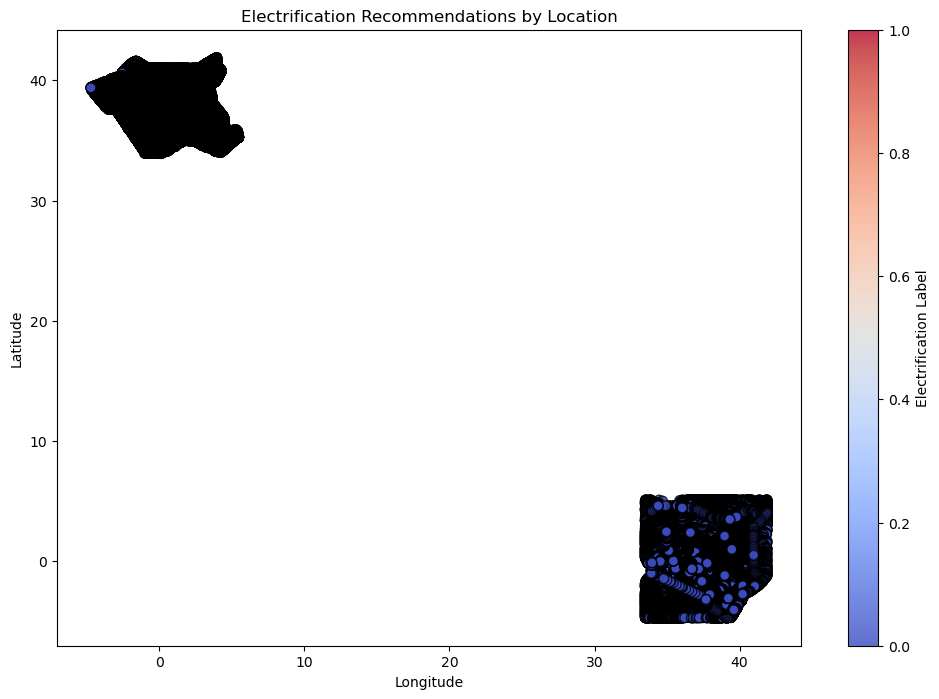

In [55]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df['Longitude'], df['Latitude'],
    c=df['Electrification_Label'], cmap='coolwarm', s=50, alpha=0.8, edgecolor='k'
)
plt.colorbar(scatter, label='Electrification Label')
plt.title('Electrification Recommendations by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Savve Models

In [56]:
# Save the MLP model
model.save("mlp_model.h5")

import joblib

# Save the scaler
scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

# Save the label encoder
label_encoder_filename = "label_encoder.pkl"
joblib.dump(label_encoder, label_encoder_filename)

# Save the HDBSCAN model
hdbscan_filename = "hdbscan_model.pkl"
joblib.dump(hdbscan_clusterer, hdbscan_filename)


['hdbscan_model.pkl']

In [57]:
import json

# Save feature names and PCA parameters
metadata = {
    "features": numeric_features,
    "pca_components": 2
}
with open("metadata.json", "w") as f:
    json.dump(metadata, f)
